In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import re
from tqdm.notebook import tqdm

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
tqdm.pandas()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv
/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv
/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv
/kaggle/input/ruddit-jigsaw-dataset/LICENSE
/kaggle/input/ruddit-jigsaw-dataset/README.md
/kaggle/input/ruddit-jigsaw-dataset/requirements.txt
/kaggle/input/ruddit-jigsaw-dataset/ruddit-comment-extraction.ipynb
/kaggle/input/ruddit-jigsaw-dataset/Dataset/create_dataset_variants.py
/kaggle/input/ruddit-jigsaw-dataset/Dataset/identityterms_group.txt
/kaggle/input/ruddit-jigsaw-dataset/Dataset/Ruddit.csv
/kaggle/input/ruddit-jigsaw-dataset/Dataset/ReadMe.md
/kaggle/input/ruddit-jigsaw-dataset/Dataset/Ruddit_

In [2]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "../input/glove6b/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [3]:
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv')

In [4]:
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes embedded URL links
    4. Removes HTML tags
    5. Removes emojis
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(r"[^a-zA-Z\d]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text




def clean(data, col):
    
    data[col] = data[col].str.replace(r"what's", "what is ")    
    data[col] = data[col].str.replace(r"\'ve", " have ")
    data[col] = data[col].str.replace(r"can't", "cannot ")
    data[col] = data[col].str.replace(r"n't", " not ")
    data[col] = data[col].str.replace(r"i'm", "i am ")
    data[col] = data[col].str.replace(r"\'re", " are ")
    data[col] = data[col].str.replace(r"\'d", " would ")
    data[col] = data[col].str.replace(r"\'ll", " will ")
    data[col] = data[col].str.replace(r"\'scuse", " excuse ")
    data[col] = data[col].str.replace(r"\'s", " ")

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return data
# def clean(data, col):
    
#     data[col] = data[col].str.replace('https?://\S+|www\.\S+', ' social medium ', regex=True)      
        
#     data[col] = data[col].str.lower()
#     data[col] = data[col].str.replace("don't", "do not" , regex=True)
#     data[col] = data[col].str.replace("i'm", "i am" , regex=True)
#     data[col] = data[col].str.replace('""', '"' , regex=True)
#     data[col] = data[col].str.replace("it's", "it is" , regex=True)
#     data[col] = data[col].str.replace("it\'s", "it is" , regex=True)
#     data[col] = data[col].str.replace("that's", "that is" , regex=True)
    
    
#     data[col] = data[col].str.replace("4", "a" , regex=True) 
#     data[col] = data[col].str.replace("2", "l", regex=True)
#     data[col] = data[col].str.replace("5", "s", regex=True) 
#     data[col] = data[col].str.replace("1", "i", regex=True) 
#     data[col] = data[col].str.replace("!", "i", regex=True) 
#     data[col] = data[col].str.replace("|", "i", regex=True) 
#     data[col] = data[col].str.replace("0", "o", regex=True) 
#     data[col] = data[col].str.replace("l3", "b", regex=True) 
#     data[col] = data[col].str.replace("7", "t", regex=True) 
#     data[col] = data[col].str.replace("7", "+", regex=True) 
#     data[col] = data[col].str.replace("8", "ate", regex=True) 
#     data[col] = data[col].str.replace("3", "e", regex=True) 
#     data[col] = data[col].str.replace("9", "g", regex=True)
#     data[col] = data[col].str.replace("6", "g", regex=True)
#     data[col] = data[col].str.replace("@", "a", regex=True)
#     data[col] = data[col].str.replace("$", "s", regex=True)
#     data[col] = data[col].str.replace("#ofc", " of fuckin course ", regex=True)
#     data[col] = data[col].str.replace("fggt", " faggot ", regex=True)
#     data[col] = data[col].str.replace("your", " your ", regex=True)
#     data[col] = data[col].str.replace("self", " self ", regex=True)
#     data[col] = data[col].str.replace("cuntbag", " cunt bag ", regex=True)
#     data[col] = data[col].str.replace("fartchina", " fart china ", regex=True)    
#     data[col] = data[col].str.replace("youi", " you ", regex=True)
#     data[col] = data[col].str.replace("cunti", " cunt i ", regex=True)
#     data[col] = data[col].str.replace("sucki", " suck i ", regex=True)
#     data[col] = data[col].str.replace("pagedelete", " page delete ", regex=True)
#     data[col] = data[col].str.replace("i'm", " i am ", regex=True)
#     data[col] = data[col].str.replace("offuck", " of fuck ", regex=True)
#     data[col] = data[col].str.replace("centraliststupid", " central ist stupid ", regex=True)
#     data[col] = data[col].str.replace("hitleri", " hitler i ", regex=True)
#     data[col] = data[col].str.replace("i've", " i have ", regex=True)
#     data[col] = data[col].str.replace("i'll", " sick ", regex=True)
#     data[col] = data[col].str.replace("fuck", " fuck ", regex=True)
#     data[col] = data[col].str.replace("f u c k", " fuck ", regex=True)
#     data[col] = data[col].str.replace("shit", " shit ", regex=True)
#     data[col] = data[col].str.replace("bunksteve", " bunk steve ", regex=True)
#     #data[col] = data[col].str.replace('wikipedia', ' social medium ', regex=True)
#     data[col] = data[col].str.replace("faggot", " faggot ", regex=True)
#     data[col] = data[col].str.replace("delanoy", " delanoy ", regex=True)
#     data[col] = data[col].str.replace("jewish", " jewish ", regex=True)
#     data[col] = data[col].str.replace("sexsex", " sex ", regex=True)
#     data[col] = data[col].str.replace("i'd", " i would ", regex=True)
#     data[col] = data[col].str.replace("'s", " is ", regex=True)
#     data[col] = data[col].str.replace("youbollocks", " you bollocks ", regex=True)
#     data[col] = data[col].str.replace("dick", " dick ", regex=True)
#     data[col] = data[col].str.replace("cuntsi", " cuntsi ", regex=True)
#     data[col] = data[col].str.replace("mothjer", " mother ", regex=True)
#     data[col] = data[col].str.replace("cuntfranks", " cunt ", regex=True)
#     data[col] = data[col].str.replace("ullmann", " jewish ", regex=True)
#     data[col] = data[col].str.replace("mr.", " mister ", regex=True)
#     data[col] = data[col].str.replace("aidsaids", " aids ", regex=True)
#     data[col] = data[col].str.replace("njgw", " nigger ", regex=True)
#     data[col] = data[col].str.replace("wiki", " social medium ", regex=True)
#     data[col] = data[col].str.replace("administrator", " admin ", regex=True)
#     data[col] = data[col].str.replace("gamaliel", " jewish ", regex=True)
#     data[col] = data[col].str.replace("rvv", " vanadalism ", regex=True)
#     data[col] = data[col].str.replace("admins", " admin ", regex=True)
#     data[col] = data[col].str.replace("pensnsnniensnsn", " penis ", regex=True)
#     data[col] = data[col].str.replace("pneis", " penis ", regex=True)
#     data[col] = data[col].str.replace("pennnis", " penis ", regex=True)
#     data[col] = data[col].str.replace("pov.", " point of view ", regex=True)
#     data[col] = data[col].str.replace("vandalising", " vandalism ", regex=True)
#     data[col] = data[col].str.replace("cock", " dick ", regex=True)
#     data[col] = data[col].str.replace("asshole", " asshole ", regex=True)
#     data[col] = data[col].str.replace("youi", " you ", regex=True)
#     data[col] = data[col].str.replace("afd", " all fucking day ", regex=True)
#     data[col] = data[col].str.replace("sockpuppets", " sockpuppetry ", regex=True)
#     data[col] = data[col].str.replace("iiprick", " iprick ", regex=True)
#     data[col] = data[col].str.replace("penisi", " penis ", regex=True)
#     data[col] = data[col].str.replace("warrior", " warrior ", regex=True)
#     data[col] = data[col].str.replace("loil", " laughing out insanely loud ", regex=True)
#     data[col] = data[col].str.replace("vandalise", " vanadalism ", regex=True)
#     data[col] = data[col].str.replace("helli", " helli ", regex=True)
#     data[col] = data[col].str.replace("lunchablesi", " lunchablesi ", regex=True)
#     data[col] = data[col].str.replace("special", " special ", regex=True)
#     data[col] = data[col].str.replace("ilol", " i lol ", regex=True)
#     data[col] = data[col].str.replace(r'\b[uU]\b', 'you', regex=True)
#     data[col] = data[col].str.replace(r"what's", "what is ", regex=True)
#     data[col] = data[col].str.replace(r"\'s", " is ", regex=True)
#     data[col] = data[col].str.replace(r"\'ve", " have ", regex=True)
#     data[col] = data[col].str.replace(r"can't", "cannot ", regex=True)
#     data[col] = data[col].str.replace(r"n't", " not ", regex=True)
#     data[col] = data[col].str.replace(r"i'm", "i am ", regex=True)
#     data[col] = data[col].str.replace(r"\'re", " are ", regex=True)
#     data[col] = data[col].str.replace(r"\'d", " would ", regex=True)
#     data[col] = data[col].str.replace(r"\'ll", " will ", regex=True)
#     data[col] = data[col].str.replace(r"\'scuse", " excuse ", regex=True)
#     data[col] = data[col].str.replace('\s+', ' ', regex=True)  # will remove more than one whitespace character
# #     text = re.sub(r'\b([^\W\d_]+)(\s+\1)+\b', r'\1', re.sub(r'\W+', ' ', text).strip(), flags=re.I)  # remove repeating words coming immediately one after another
#     data[col] = data[col].str.replace(r'(.)\1+', r'\1\1', regex=True) # 2 or more characters are replaced by 2 characters
# #     text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
#     data[col] = data[col].str.replace("[:|♣|'|§|♠|*|/|?|=|%|&|-|#|•|~|^|>|<|►|_]", '', regex=True)
    
    
#     data[col] = data[col].str.replace(r"what's", "what is ", regex=True)    
#     data[col] = data[col].str.replace(r"\'ve", " have ", regex=True)
#     data[col] = data[col].str.replace(r"can't", "cannot ", regex=True)
#     data[col] = data[col].str.replace(r"n't", " not ", regex=True)
#     data[col] = data[col].str.replace(r"i'm", "i am ", regex=True)
#     data[col] = data[col].str.replace(r"\'re", " are ", regex=True)
#     data[col] = data[col].str.replace(r"\'d", " would ", regex=True)
#     data[col] = data[col].str.replace(r"\'ll", " will ", regex=True)
#     data[col] = data[col].str.replace(r"\'scuse", " excuse ", regex=True)
#     data[col] = data[col].str.replace(r"\'s", " ", regex=True)

#     # Clean some punctutations
#     data[col] = data[col].str.replace('\n', ' \n ', regex=True)
#     data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3', regex=True)
#     # Replace repeating characters more than 3 times to length of 3
#     data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1', regex=True)    
#     # Add space around repeating characters
#     data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ', regex=True)    
#     # patterns with repeating characters 
#     data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1', regex=True)
#     data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
#     data[col] = data[col].str.replace(r'[ ]{2,}',' ', regex=True).str.strip()   
#     data[col] = data[col].str.replace(r'[ ]{2,}',' ', regex=True).str.strip()   
#     data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
#     return data


lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

df_train_new = clean(train, 'comment_text')
df_train_new['clean_text'] = df_train_new['comment_text'].progress_apply(text_cleaning)

# tqdm.pandas()
# df_train_new['clean_text'] = df_train_new['comment_text'].progress_apply(text_cleaning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykern

  0%|          | 0/159571 [00:00<?, ?it/s]

In [5]:

lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

# tqdm.pandas()
# df_train_new['clean_text'] = df_train_new['comment_text'].progress_apply(text_cleaning)
df_train_new = clean(train, 'comment_text')
df_train_new['clean_text'] = df_train_new['comment_text'].progress_apply(text_cleaning)

texts = df_train_new['clean_text'].values
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
y = df_train_new[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykern

  0%|          | 0/159571 [00:00<?, ?it/s]

In [6]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Vocabulary size: 181442
Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [7]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [8]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [9]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12240  1261  6749   380  6264  1099]
validation:  [3054  334 1700   98 1613  306]


In [10]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 8795    16    12    80   145     4   252   378    96  9158    23  1657
     4    23   165    96 18363   238  1113     7   818  8795 52892   767
  1923 34766    57 34288  2625  1274  8795 10389   886   448 11151     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [11]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: ../input/glove6b/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [12]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

2021-12-20 12:17:22.682501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 12:17:22.771223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 12:17:22.771980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 12:17:22.773488: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [14]:
model = Model(sequence_input, preds)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss = 'binary_crossentropy',
             optimizer=opt,
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          18144300  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

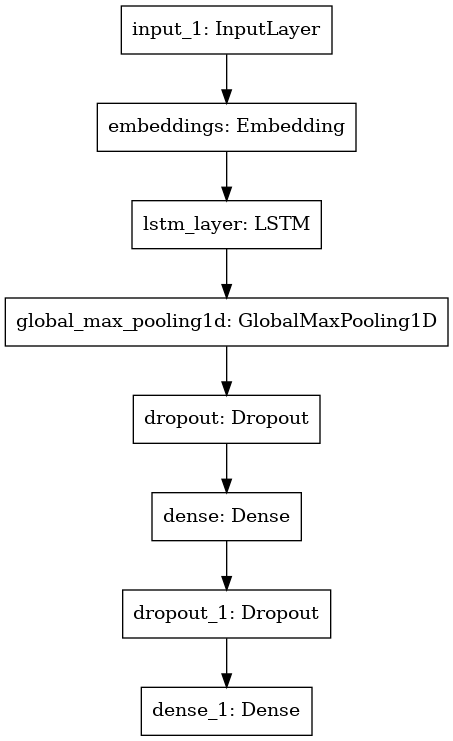

In [15]:
tf.keras.utils.plot_model(model)

In [16]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_val, y_val), callbacks=[callback])

Training progress:
Epoch 1/10


2021-12-20 12:17:26.666952: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-20 12:17:28.850780: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3990/3990 [==============================] - 47s 11ms/step - loss: 0.1182 - accuracy: 0.7825 - val_loss: 0.0707 - val_accuracy: 0.9940
Epoch 2/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0743 - accuracy: 0.9271 - val_loss: 0.0653 - val_accuracy: 0.9940
Epoch 3/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0657 - accuracy: 0.9618 - val_loss: 0.0603 - val_accuracy: 0.9940
Epoch 4/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0619 - accuracy: 0.9741 - val_loss: 0.0569 - val_accuracy: 0.9940
Epoch 5/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0587 - accuracy: 0.9829 - val_loss: 0.0566 - val_accuracy: 0.9940
Epoch 6/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0565 - accuracy: 0.9877 - val_loss: 0.0543 - val_accuracy: 0.9940
Epoch 7/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0548 - accuracy: 0.9904 - val_loss: 0.0556 - val_accura

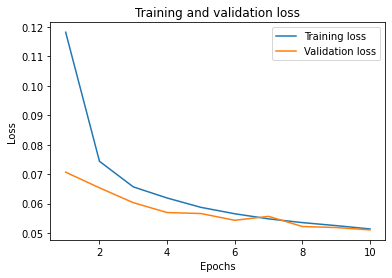

In [17]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

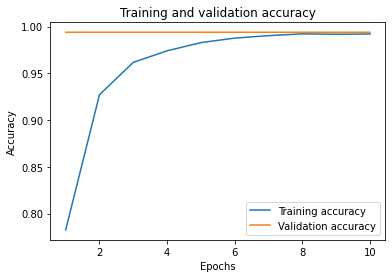

In [18]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [19]:
validation_data = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv')
validation_data.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


In [20]:
# new_validation_data = clean(validation_data, 'less_toxic')
# new_validation_data = clean(validation_data, 'more_toxic')
# new_validation_data['clean_less_toxic'] = new_validation_data['less_toxic'].progress_apply(text_cleaning)
# new_validation_data['clean_more_toxic'] = new_validation_data['more_toxic'].progress_apply(text_cleaning)

In [21]:
# less_toxic_sample = new_validation_data['clean_less_toxic'].values
# more_toxic_sample = new_validation_data['clean_more_toxic'].values

# sequences = tokenizer.texts_to_sequences(less_toxic_sample)
# less_toxic_data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

# sequences = tokenizer.texts_to_sequences(more_toxic_sample)
# more_toxic_data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [22]:
# less_toxic_predictions = model.predict(less_toxic_data)
# more_toxic_predictions = model.predict(more_toxic_data)

In [23]:
# weights = [2, 5, 0.5, 0.5, 0.5, 1]
# print((np.dot(less_toxic_predictions, weights) < np.dot(more_toxic_predictions, weights)).sum()/len(more_toxic_predictions))

In [24]:
# df_predictions = pd.DataFrame({'less_toxic': less_toxic_sample,
#                                'more_toxic': more_toxic_sample,
#                                'score_1': np.dot(less_toxic_predictions, weights),
#                                'score_2': np.dot(more_toxic_predictions, weights)})

In [25]:
# df_wrong_predictions = df_predictions[df_predictions['score_2'] < df_predictions['score_1'] ]

In [26]:
# df_wrong_predictions.iloc[5]['more_toxic']

In [27]:
# validation_data.iloc[6]['more_toxic']

In [28]:
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")


test_data = clean(df_sub, 'text')
test_data['clean_text'] = test_data['text'].progress_apply(text_cleaning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykern

  0%|          | 0/7537 [00:00<?, ?it/s]

In [29]:
texts = test_data['clean_text'].values  
sequences = tokenizer.texts_to_sequences(texts)
test_data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', test_data.shape)

Shape of data tensor: (7537, 200)


In [30]:
weights = [2, 5, 0.5, 0.5, 0.5, 1]
predictions = model.predict(test_data)
df_sub['score'] = np.dot(predictions, weights)

df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)